# HW4-6 文字探勘: 從動畫電影Zootopia分析角色常用字與劇情情緒走向

### * 問題意識：
Zootopia是一部關於種族歧視的動畫電影。我好奇在這部電影裡，不同角色（代表著不同的社會地位與身份）的用詞是否有所差異，且這種差異是否某種程度上跟種族歧視有關（重要字分析）。另外，我也想知道是否能根據劇本內容，分析出電影的情節走向（情緒分析）。

### * 分析流程：
1. **文字預處理**
    - 從[IMSDb](https://www.imsdb.com/scripts/Zootopia.html)對Zootopia的劇本內容爬蟲 [爬蟲code](https://github.com/yichingchan1013/CSX-DataScience/blob/master/hw4-6/scrape%20zootopia.ipynb) [爬蟲data](https://github.com/yichingchan1013/CSX-DataScience/blob/master/hw4-6/zootopia.txt)
    - 將劇本內容處理成[分幕-角色-台詞]的dataframe格式，方便後續分析
    - 電影共73個角色，只取其中6個主要角色的台詞進行分析（不然台詞數不夠）
    

2. **主要角色常用字**
    - 用TF-IDF找出角色的重要用字，文本經過停用字(stopwords)、字根化(stemming)處理
    - 用TF-IDF的結果，畫出文字雲
    - 製作字詞共現矩陣(co-occurence matrix)，畫出熱圖(heatmap)和字詞網絡圖(network graph)
    

3. **劇本情緒分析**
    - 以分幕為單位，用VADER計算個幕的情緒分數
    - 比較女主角Judy在孩童時期、學生時期、成人時期的情緒差異
    - 比較男女主角Nick和Judy的情緒走向
   

## 文字預處理: 把劇本內容格式化，並去除雜訊

In [1020]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
import re
import codecs
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import networkx as nx

#設定工作路徑
os. chdir("/Users/yichingchan/Documents/Practice-python/text mining/")


In [1023]:
#只抓出出角色和對話內容
with codecs.open('zootopia.txt', 'r', 'utf8') as f:

  # read the file content
    f = f.read()
    f = f.split("A JUNGLE - NIGHT", 1)[1]
    f = f.split("THE END", 1)[0]

  # store all the clean text that's accumulated
    spoken_text = list()

    
    character = None
    dialogue = ""
    scene = 1
    
  # split the file into a list of strings, with each line a member in the list
    for line in f.split('\n'):
        
        # split the line into a list of words in the line
        words = line.split()

        # if there are no words, do nothing
        if not words:
            continue
        
        #第幾幕
        if len(line) - len(line.lstrip())> 55:
            scene = line.lstrip()
                          
                               
        # if there's a good amount of whitespace to the left, this is a spoken line
        if len(line) - len(line.lstrip()) > 4:
            # if this line is a person identifier, get the person's name
            if (len(words[0]) > 1) and (all(i.isupper() for i in words[0]) or words[0] == 'MRS.' or words[0] == 'MR.') :          
                spoken_text.append({'character': character, 'dialogue' : dialogue, 'scene' : scene})
                dialogue = ""
                character = line.strip()
                               
            else: 
                dialogue += line.strip() + ' '
    
#print(spoken_text)

In [1026]:
#文字轉成df方便後續分析
df_text = pd.DataFrame(spoken_text)
df_text.head()

,character,dialogue,scene
0,None,,1
1,YOUNG JUDY (V.O.),Fear. Treachery. Bloodlust! Thousands of years...,1
2,CUT TO:,,1
3,YOUNG JUDY,"Blood, blood, blood!",1
4,YOUNG JUDY (CONT'D),And death.,1


In [1027]:
#remove non-dialogue row
df_text.drop(index = [0,1,968], axis=0, inplace=True)
df_text.drop(df_text[df_text['character']==''].index, axis=0, inplace=True)
df_text.drop(df_text[df_text['dialogue']==''].index, axis=0,inplace=True)
df_text.drop(df_text[df_text['character']=='CUT TO:'].index, axis=0,inplace=True)


In [1028]:
#分幕數字處理乾淨
df_text['scene'] = df_text['scene'].apply(lambda x: str(x).split('.\r',1)[0])

In [1029]:
#把名字後面的括號刪掉 #括號刪掉後，名字後面會有兩個空格
df_text['character'] = df_text['character'].apply(lambda x: x.split("(",maxsplit=1)[0])

In [1030]:
#刪掉名字前後的空格
df_text['character'] = df_text['character'].apply(lambda x: x.rstrip())
df_text['character'] = df_text['character'].apply(lambda x: x.lstrip())

In [1031]:
#手動確認只剩對話，沒有其他雜訊
df_text.to_csv('zoo.csv')

### 初步檢查文字內容

劇本的發現角色共有73個，但除了男女主角有超過180句台詞之外，其他角色的台詞數都不超過55句，甚至大多數都不超過10句。因此我從[電影角色列表網站](https://disney.fandom.com/wiki/Category:Zootopia_characters)把主次要角色（共28個）抓下來，編碼到格式化的資料中。但除了前六大主角之外，其他角色台詞數仍不超過20句，因此我後面的分析都只針對這6位主要角色。

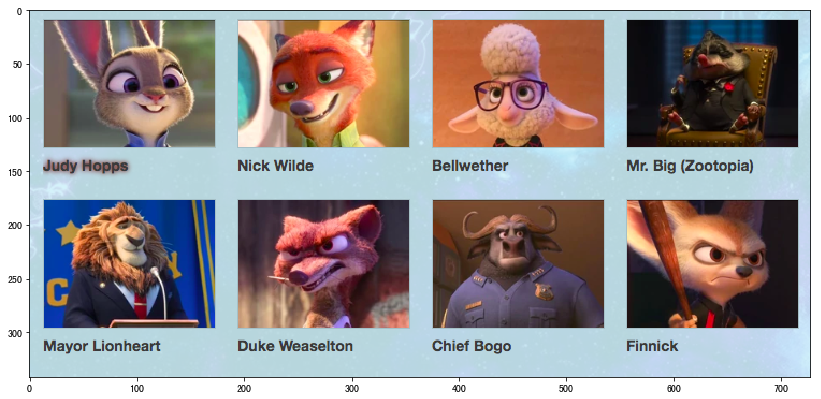

In [1167]:
#六大角色
from PIL import Image
img = Image.open('/Users/yichingchan/Documents/Practice-python/text mining/character.png') # 這時候還是 PIL object
img = np.array(img) #轉成array
plt.figure(figsize=(14,10))
plt.imshow(img)
plt.show()

In [1033]:
df_text['character'].value_counts()
#發現同個角色會有不同名字（例如不同時期JUDY有不同名稱）

HOPPS                               308
NICK                                182
BOGO                                 54
STU HOPPS                            43
BELLWETHER                           42
BONNIE HOPPS                         35
FLASH                                24
CLAWHAUSER                           22
YOUNG JUDY                           21
LIONHEART                            20
MR. BIG                              15
DUKE WEASELTON                       13
GIDEON GREY                          12
GAZELLE                              10
JUDY                                 10
MAJOR FRIEDKIN                        9
MRS. OTTERTON                         9
MEAN KID ANIMAL                       7
JERRY JUMBEAUX, JR.                   7
FRU FRU SHREW                         7
YAX THE HIPPIE YAK                    7
YAX                                   6
ORYX POOTOSSER                        6
DOUG                                  6
YOUNG NICK                            5


In [1036]:
#爬蟲電影角色列表 #主要角色總共有28個
name_list = []
with open('name.csv', 'r') as f: 
    next(f) #no header
    for line in f:
        name_list.append(line.upper().replace('\n', ''))
name_list.remove('MR. OTTERTON') #把水獺丈夫刪掉
name_list          

['BELLWETHER',
 'CHIEF BOGO',
 'BUCKY AND PRONK ORYX-ANTLERSON',
 'CLAWHAUSER',
 'DOUG (ZOOTOPIA)',
 'DR. BADGER',
 'FABIENNE GROWLEY',
 'FINNICK',
 'FLASH',
 'FRU FRU',
 'GAZELLE',
 'GIDEON GREY',
 'BONNIE AND STU HOPPS',
 'JUDY HOPPS',
 'JERRY JUMBEAUX JR.',
 'KOSLOV',
 'MAYOR LIONHEART',
 'PETER MOOSEBRIDGE',
 'MR. BIG (ZOOTOPIA)',
 'MR. MANCHAS',
 'MRS. OTTERTON',
 'PRISCILLA',
 'SWINTON',
 'DUKE WEASELTON',
 'NICK WILDE',
 'WOOLTER AND JESSE',
 'YAX',
 'ZOOTOPIA POLICE OFFICERS']

In [1037]:
#只編碼主要角色
df_text['main_chara'] = None 

for name in name_list:
    for i in range(len(df_text)):
        character = df_text.iloc[i,0] #col0 =character 
        if 'MR' in character:
            if character.split(' ')[1] in name:
                df_text.iloc[i,2] = name #col2 = main charater
        else:        
            for ele in character.split(' '):            
                if ele in name:               
                    df_text.iloc[i,3] = name #col2 = main charater                

In [1038]:
df_text.head() #各時期的Judy都統一編碼為JUDY HOPPS(BONNIE AND STU HOPPS被蓋掉)

,character,dialogue,scene,main_chara
3,YOUNG JUDY,"Blood, blood, blood!",1,JUDY HOPPS
4,YOUNG JUDY,And death.,1,JUDY HOPPS
5,YOUNG JUDY,"Back then, the world was divided in two. Vicio...",2,JUDY HOPPS
6,YOUNG JUDY,"But over time, we evolved, and moved beyond ou...",2,JUDY HOPPS
7,YOUNG JUDY,"Now, predator and prey live in harmony.",2,JUDY HOPPS


In [1039]:
df_text['main_chara'].value_counts() #主要角色的台詞數

JUDY HOPPS                        417
NICK WILDE                        187
CHIEF BOGO                         54
BELLWETHER                         47
FLASH                              24
CLAWHAUSER                         22
MAYOR LIONHEART                    20
GIDEON GREY                        15
DUKE WEASELTON                     13
YAX                                13
GAZELLE                            10
FRU FRU                             7
JERRY JUMBEAUX JR.                  7
DOUG (ZOOTOPIA)                     6
BUCKY AND PRONK ORYX-ANTLERSON      6
DR. BADGER                          5
MR. MANCHAS                         4
WOOLTER AND JESSE                   4
FINNICK                             3
PETER MOOSEBRIDGE                   2
ZOOTOPIA POLICE OFFICERS            1
PRISCILLA                           1
Name: main_chara, dtype: int64

# 文本分析

## 第一部分：角色常用字

我把同個角色的台詞合併，因此總共會有6個文本（對應6個角色）。為了讓關鍵字分析的結果有意義，我有把文本內容處理過，包含只取英文字、字母全部改為小寫、停用詞、字根化等，並刪掉少於3個字母的詞。另外，我也有客製化幾個停用字，想讓關鍵字分析的結果更有意義。

In [1040]:
#只看主要角色的對話內容
df_main = df_text.groupby('main_chara')['dialogue'].apply(' '.join).reset_index()
df_main

,main_chara,dialogue
0,BELLWETHER,"(sotto, to Gideon) Uh, I'm pretty much sure it..."
1,BUCKY AND PRONK ORYX-ANTLERSON,Don't expect us to apologize for it. You shut...
2,CHIEF BOGO,"All right, all right. Everybody sit. I've got..."
3,CLAWHAUSER,O-M goodness! They really did hire a bunny. Wh...
4,DOUG (ZOOTOPIA),(into phone) You got Doug here. What's the mar...
5,DR. BADGER,"Mayor Lionheart, please, we're doing everythin..."
6,DUKE WEASELTON,"Catch me if you can, Cottontail! Whoa. Coming..."
7,FINNICK,"(super-deep voice) You kiss me tomorrow, I'll ..."
8,FLASH,Nice to... (beat) (beat) see you... (beat) (be...
9,FRU FRU,"Ohmygawd, did you see those leopard print jegg..."


In [1075]:
#自訂停用字
stop_words = stopwords.words('english')
stopwords_extend = ['gonna','gotta','okay','really','well','first','one','two','three']
stop_words.extend(stopwords_extend)

In [1099]:
#刪除冗言贅字
df_main['tidy_dialogue'] = None
for i in range(len(df_main)):
    text = re.sub('[^a-zA-Z]', ' ', df_main.iloc[i,1]) #只抓大小寫英文字母，指定dialogue欄
    text = text.lower() #都轉成小寫方便分析
    text = text.split() 
    ps = PorterStemmer() #字根還原
    text = [ps.stem(word) for word in text if not word in set(stop_words)]
    text = [word for word in text if len(word) > 3] #只取三個letter以上的字詞
    text = ' '.join(text) #return string
    df_main.iloc[i,2] = text #整理後的文字回傳

df_main.head()

,main_chara,dialogue,tidy_dialogue
0,BELLWETHER,"(sotto, to Gideon) Uh, I'm pretty much sure it...",sotto gideon pretti much sure pronounc lookit ...
1,BUCKY AND PRONK ORYX-ANTLERSON,Don't expect us to apologize for it. You shut...,expect apolog shut bunni turn depress music sh...
2,CHIEF BOGO,"All right, all right. Everybody sit. I've got...",right right everybodi item docket need acknowl...
3,CLAWHAUSER,O-M goodness! They really did hire a bunny. Wh...,good hire bunni tell even cuter thought gasp r...
4,DOUG (ZOOTOPIA),(into phone) You got Doug here. What's the mar...,phone doug mark cheetah sahara squar phone ser...


In [1100]:
#只取前六個話多的角色
top = ['JUDY HOPPS', 'NICK WILDE', 'CHIEF BOGO','BELLWETHER','FLASH','CLAWHAUSER']
df_top = df_main[pd.DataFrame(df_main.main_chara.tolist()).isin(top).any(1)]
df_top.head()

,main_chara,dialogue,tidy_dialogue
0,BELLWETHER,"(sotto, to Gideon) Uh, I'm pretty much sure it...",sotto gideon pretti much sure pronounc lookit ...
2,CHIEF BOGO,"All right, all right. Everybody sit. I've got...",right right everybodi item docket need acknowl...
3,CLAWHAUSER,O-M goodness! They really did hire a bunny. Wh...,good hire bunni tell even cuter thought gasp r...
8,FLASH,Nice to... (beat) (beat) see you... (beat) (be...,nice beat beat beat beat today sure plate numb...
13,JUDY HOPPS,"Blood, blood, blood! And death. Back then, t...",blood blood blood death back world divid vicio...


### TF-IDF 詞頻矩陣與文字雲

將字詞處理完之後，我將每個角色台詞轉換成詞頻矩陣，兩種方法：
第一種是直接算詞頻(term-frequency)，並畫出常用字的文字雲。
第二種是是計算IDF權重，再根據TF-IDF的結果畫出重要字的文字雲。（其中有個角色因為詞頻向量有太多零，畫不出圖，只好用文字列出前10重要字詞）。

In [1101]:
corpus = df_top['tidy_dialogue'].values.tolist()

In [1102]:
# TF-IDF
# coding:utf-8 

#TF(get Bags of Words)
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  
X = vectorizer.fit_transform(corpus) #計算tf-idf
word = vectorizer.get_feature_names()  #獲取詞袋模型中的所有詞語

#IDF
from sklearn.feature_extraction.text import TfidfTransformer  
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) #將文字轉為詞頻矩陣 

In [1103]:
#詞頻矩陣(可以看出常用字)
df_tf = pd.DataFrame(X.toarray(), columns = word, index = top)
df_tf

,abandon,absenc,absolut,acacia,academi,access,accomplish,accord,account,accu,...,wrong,wuzzi,yakketi,yard,yeah,year,yike,young,zero,zootopia
JUDY HOPPS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
NICK WILDE,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHIEF BOGO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
BELLWETHER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FLASH,0,1,2,0,1,0,0,1,1,1,...,0,0,0,0,12,3,0,1,1,6
CLAWHAUSER,0,0,0,1,0,1,1,0,0,0,...,3,1,1,2,8,2,0,0,0,4


In [1105]:
#文字雲
def get_wordcloud(df, index, BOW):
    freq = df.to_dict(orient='records')[index]
    character = df.index[index]
    wc = WordCloud(background_color="white",max_words=20).generate_from_frequencies(freq)   
    plt.title('%s\'s words in wordcloud %s' % (character, BOW))
    plt.imshow(wc)
    #plt.axis("off")
    plt.show()

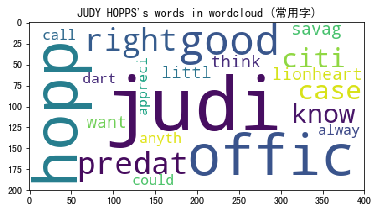

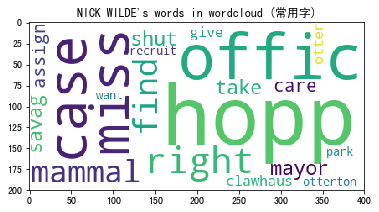

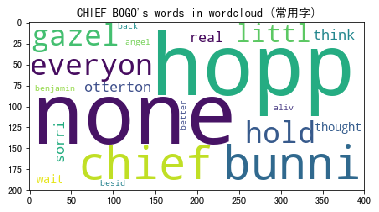

beat      7
call      2
hump      2
sever     2
sure      2
camel     1
know      1
nice      1
nick      1
number    1
Name: BELLWETHER, dtype: int64


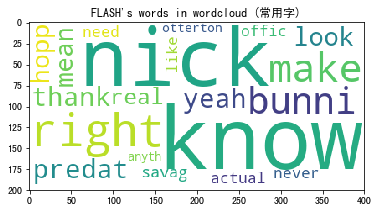

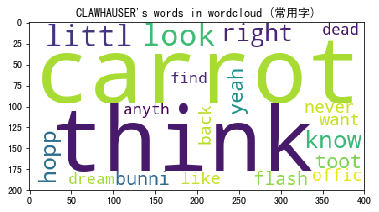

In [1108]:
#畫出每個角色top10常用字的文字雲
for i in range(len(df_tf)):
    try:
        get_wordcloud(df_tf, i, '(常用字)')
    except:
        print(df_tf.iloc[i].nlargest(10))

In [1104]:
#TFIDF矩陣（可以看出重要字）
df_tfidf = pd.DataFrame(tfidf.toarray(), columns = word, index = top)
print(tfidf.toarray().shape)
df_tfidf

(6, 1079)


,abandon,absenc,absolut,acacia,academi,access,accomplish,accord,account,accu,...,wrong,wuzzi,yakketi,yard,yeah,year,yike,young,zero,zootopia
JUDY HOPPS,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.040839,0.000000,0.000000,0.000000,0.000000,0.095316
NICK WILDE,0.055998,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHIEF BOGO,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.063706,0.000000,0.107383,0.000000,0.000000,0.000000
BELLWETHER,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FLASH,0.000000,0.016175,0.032351,0.00000,0.016175,0.00000,0.00000,0.016175,0.016175,0.016175,...,0.000000,0.00000,0.00000,0.00000,0.115154,0.039792,0.000000,0.016175,0.016175,0.067190
CLAWHAUSER,0.000000,0.000000,0.000000,0.02567,0.000000,0.02567,0.02567,0.000000,0.000000,0.000000,...,0.077009,0.02567,0.02567,0.05134,0.121831,0.042099,0.000000,0.000000,0.000000,0.071086


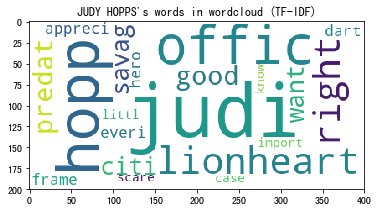

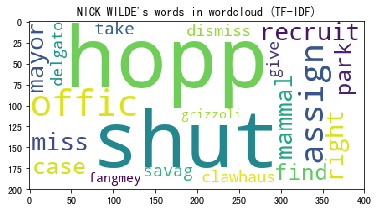

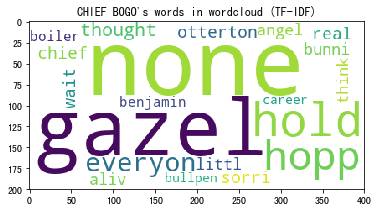

beat         0.802995
sever        0.331393
hump         0.229427
sure         0.229427
priscilla    0.165696
today        0.165696
call         0.147105
camel        0.114714
nick         0.114714
plate        0.114714
Name: BELLWETHER, dtype: float64


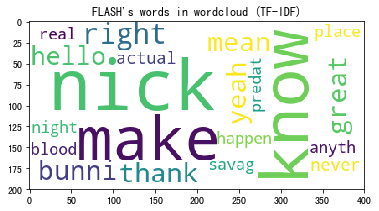

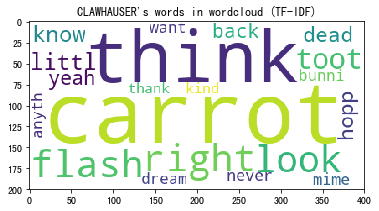

In [1106]:
#每個角色的top10重要字詞文字雲
for i in range(len(df_tfidf)):
    try:
        get_wordcloud(df_tfidf, i, '(TF-IDF)')
    except:
        print(df_tfidf.iloc[i].nlargest(10))


**小結論**

- 兩種方法的結果並沒有差異太多，但經過IDF權重處理的結果應較有意義，因為每個文本台詞數差異很大，只看詞頻可能失準。
- 可以看出來主角Judy幾個重要字：savage,predator跟野蠻、肉食動物、獵食有關，而她本身身為草食動物；officer, lionheart, city則跟「方程式」有關，也是她的嚮往。Nick除了常稱呼Judy的姓氏外，重要字有shut。蠻牛局長（Chief Bogo）重要字是none和Gazelle(電影裡面的羚羊歌手)。綿羊副市長最重要的字是beat，或許跟她內心對肉食動物有所怨恨有關。金豹警員重要字是carrot，可能跟某一幕他說有準備蘿蔔甜甜圈給Judy有關。

 

### CO-OCCURENCE 觀察不同角色間字詞共現的程度

我從6個角色中，每個角色選擇前10大重要字，再去算出這些字詞在每個角色台詞中的共現性，並將結果視覺化。

In [1117]:
#選擇每個角色的top10重要字
keyword = []
for i in range(len(df_tfidf)):
    top = df_tfidf.iloc[i].nlargest(10).index.tolist() 
    keyword.append(top)
    
key_union = list(set().union(*keyword))

In [1118]:
#製作共詞矩陣 
n = len(key_union)
coocc = [[0 for x in range(n)] for y in range(n)]  # create n*n matrix

for i in range(n):
    term1 = key_union[i]
    for k in range(n):
        term2 = key_union[k]
        count = 0
        
        for dialogue in corpus:
            if term1 != term2:
                if term1 in dialogue and term2 in dialogue:
                    count += 1
        coocc[i][k] = count
        coocc[k][i] = count        

In [1119]:
term_coocc =  pd.DataFrame(coocc, columns = key_union, index=key_union)
term_coocc

,mayor,plate,assign,gazel,call,camel,bunni,recruit,make,sorri,...,know,flash,hopp,savag,want,mean,case,today,littl,none
mayor,0,1,1,0,3,1,3,1,1,2,...,3,0,3,3,3,1,3,0,3,0
plate,1,0,0,0,3,3,2,0,2,2,...,3,1,2,2,2,2,2,1,2,1
assign,1,0,0,0,1,0,1,1,0,0,...,1,0,1,1,1,0,1,0,1,0
gazel,0,0,0,0,1,0,1,0,0,1,...,0,0,1,0,0,1,1,0,1,1
call,3,3,1,1,0,3,5,1,2,4,...,5,1,5,4,4,3,5,1,5,2
camel,1,3,0,0,3,0,2,0,2,2,...,3,1,2,2,2,2,2,1,2,1
bunni,3,2,1,1,5,2,0,1,2,4,...,4,1,5,4,4,3,5,0,5,2
recruit,1,0,1,0,1,0,1,0,0,0,...,1,0,1,1,1,0,1,0,1,0
make,1,2,0,0,2,2,2,0,0,2,...,2,1,2,2,2,2,2,0,2,1
sorri,2,2,0,1,4,2,4,0,2,0,...,3,1,4,3,3,3,4,0,4,2


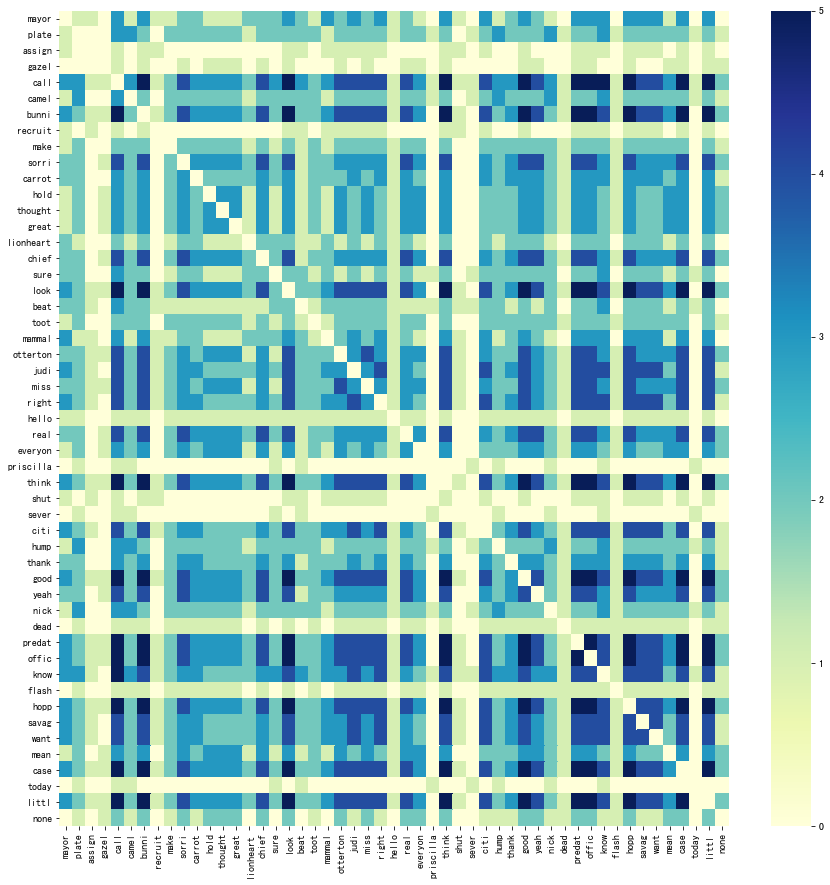

In [1120]:
#heatmap
plt.figure(figsize=(15,15))
sns.heatmap(term_coocc,cmap="YlGnBu")

In [1121]:
#get counter in the format (source,target, counter)
edges = []
n = len(key_union)
for r in range(n): #row
    for c in range(r, n): #col
        edge = (key_union[r], key_union[c])
        counter = term_coocc.iloc[r,c]
        for num in range(counter):
            edges.append(edge)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


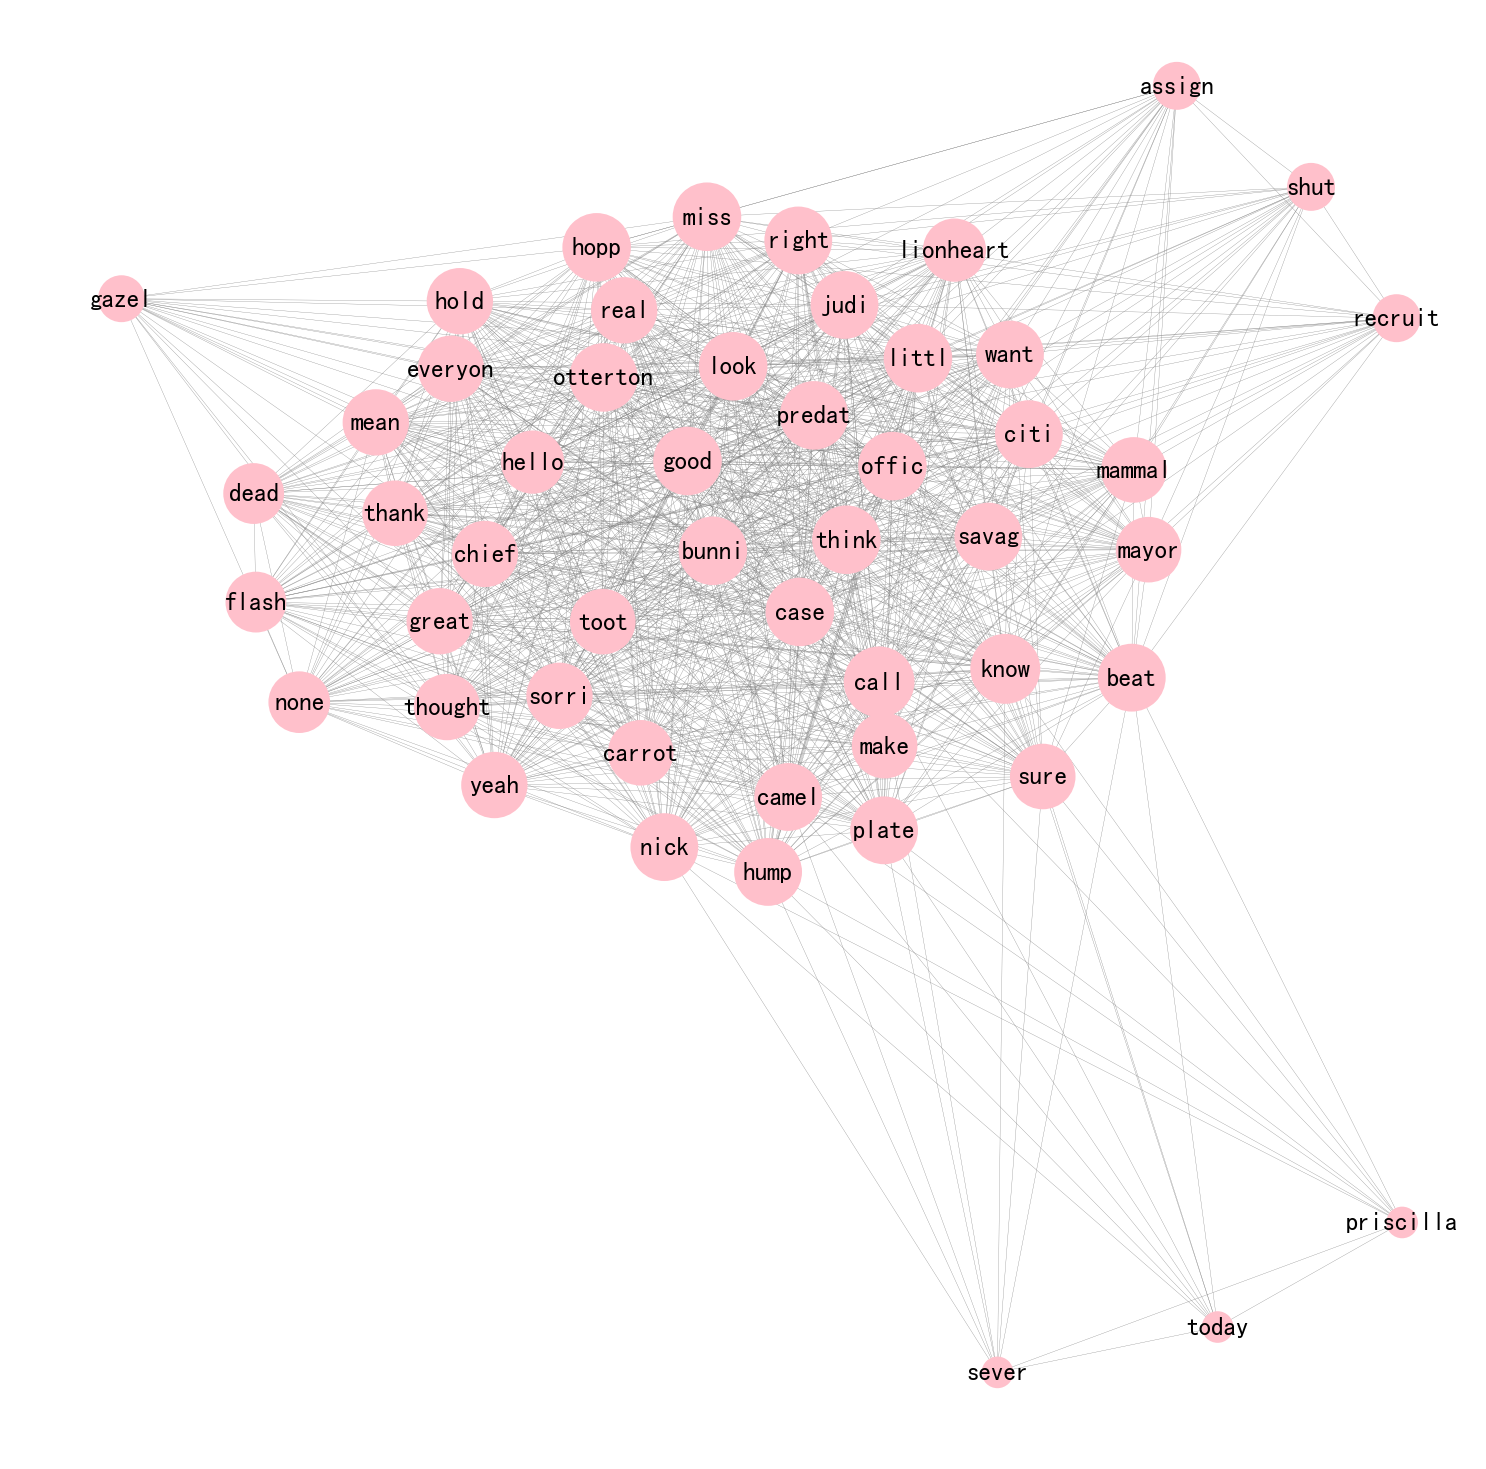

In [1122]:
#共現圖
plt.figure(figsize=(20, 20))
g = nx.Graph()
g.add_edges_from(edges)
pos=nx.spring_layout(g)
d = dict(g.degree)
nx.draw(g, pos, with_labels = True, node_size=[ v * 100  for v in d.values()], 
        node_color="pink", node_shape="o", linewidths = 0, 
        font_size=25, font_color = 'black', font_weight="bold", width=0.3, edge_color="grey")



**小結論**:

只能粗略的發現，Nick和綿羊副市長的重要字並沒有跟其他人的重要字有太多的連結。中間的字共現程度很接近，可能是因為這些字詞大部分屬於日常用字，如果想要有更乾淨的結果，可能要做NER，把幾個重要且不那麼常見的字詞選出來。

## 第二部分：電影情緒分析
 
我用VADER來計算文本的情緒分數，由於標點符號會影響分析，因此這部分文本我沒有處理。
 - A. 為了分析電影的整體情緒走向，我將台詞用分幕來分類，整部電影共有1-109幕，並計算每一幕的綜合情緒分數。 
 - B. 再來是角色的情緒走向
     - 1) 我計算女主角Judy在不同時期（幼年、學生、成人）的情緒分數，發現成人後女主角開始有較多的負面情緒 
     - 2) 比較男女主角的情緒差異，發現女主角平均來說比男主角樂觀開朗，男主角基本上很厭世。 

In [1128]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [1129]:
def sentiment_analyzer_scores(sentence): #return dictionary
    score = analyser.polarity_scores(sentence)
    return score 
    #print("{:-<40} {}".format(sentence, str(score)))

In [1130]:
#檢查資料
df_text.head()

,character,dialogue,scene,main_chara
3,YOUNG JUDY,"Blood, blood, blood!",1,JUDY HOPPS
4,YOUNG JUDY,And death.,1,JUDY HOPPS
5,YOUNG JUDY,"Back then, the world was divided in two. Vicio...",2,JUDY HOPPS
6,YOUNG JUDY,"But over time, we evolved, and moved beyond ou...",2,JUDY HOPPS
7,YOUNG JUDY,"Now, predator and prey live in harmony.",2,JUDY HOPPS


In [1133]:
#28個主要角色的台詞
df_script = df_text.dropna().drop(columns='character')
df_script.head()

,dialogue,scene,main_chara
3,"Blood, blood, blood!",1,JUDY HOPPS
4,And death.,1,JUDY HOPPS
5,"Back then, the world was divided in two. Vicio...",2,JUDY HOPPS
6,"But over time, we evolved, and moved beyond ou...",2,JUDY HOPPS
7,"Now, predator and prey live in harmony.",2,JUDY HOPPS


In [1132]:
'''#文字預處理
df_script['tidy_dialogue'] = None
for i in range(len(df_script)):
    text = re.sub('[^a-zA-Z]', ' ', df_script.iloc[i,0]) #只抓大小寫英文字母，指定dialogue欄
    text = text.lower() #都轉成小寫方便分析
    text = text.split() 
    ps = PorterStemmer() #字根還原
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = [word for word in text if len(word) > 3] #只取三個letter以上的字詞
    text = ' '.join(text) #return string
    df_script.iloc[i,3] = text #整理後的文字回傳
df_script.head()'''

"#文字預處理\ndf_script['tidy_dialogue'] = None\nfor i in range(len(df_script)):\n    text = re.sub('[^a-zA-Z]', ' ', df_script.iloc[i,0]) #只抓大小寫英文字母，指定dialogue欄\n    text = text.lower() #都轉成小寫方便分析\n    text = text.split() \n    ps = PorterStemmer() #字根還原\n    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]\n    text = [word for word in text if len(word) > 3] #只取三個letter以上的字詞\n    text = ' '.join(text) #return string\n    df_script.iloc[i,3] = text #整理後的文字回傳\ndf_script.head()"

### A. 整體情緒走向

基本上整體的情緒都蠻正面的。細部來看，電影前半段大部份是正面情緒，後半段開始有負面情緒，符合一般電影的情節設置。

In [1136]:
#根據分幕來分析
df_scene = df_script.groupby('scene')['dialogue'].apply(' '.join).reset_index()
df_scene

df_scene['positive'] = None
df_scene['negative'] = None
df_scene['compound'] = None

for i in range(len(df_scene)):
    text = df_scene.iloc[i]['dialogue']
    pos = sentiment_analyzer_scores(text)['pos']
    neg = sentiment_analyzer_scores(text)['neg']
    com = sentiment_analyzer_scores(text)['compound']
    df_scene.iloc[i,2] = pos
    df_scene.iloc[i,3] = neg
    df_scene.iloc[i,4] = com
df_scene.head()     

,scene,dialogue,positive,negative,compound
0,1,"Blood, blood, blood! And death.",0,0.512,-0.636
1,10,"Just a stupid, carrot farming dumb bunny. 10. ...",0.179,0.079,0.8172
2,100,Trust me! SPEED! UP! 100. Stop the train! Hey...,0.2,0.235,0.4344
3,101,Ow. 101. Come on! We gotta get to the ZPD. Cu...,0.145,0.138,-0.7636
4,106,"Did I falsely imprison those animals? Well, ye...",0.253,0.105,0.5267


In [1137]:
#分幕改為int，並按大小排序
df_scene['scene'] = df_scene['scene'].apply(lambda x: int(x))
df_scene.set_index('scene', inplace=True)
df_scene.sort_index(inplace=True)

Text(0.5, 1.0, '電影情節的情緒走向（綜合情緒分數）')

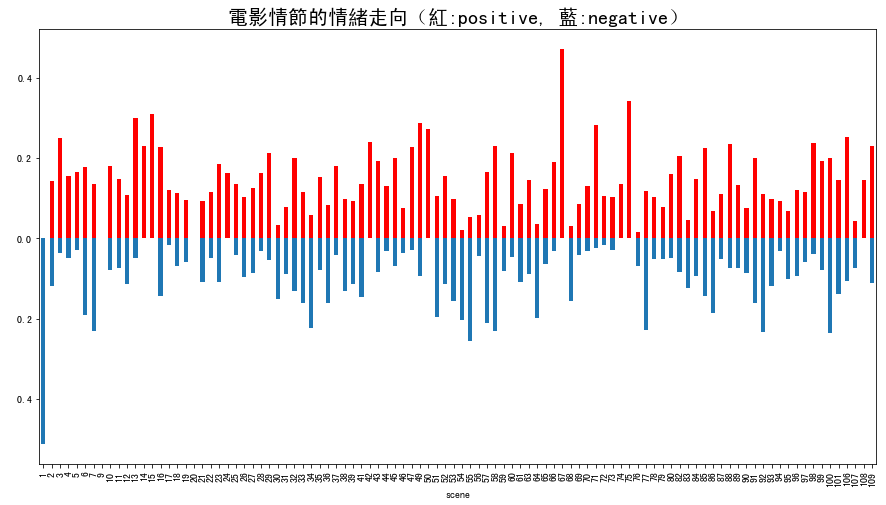

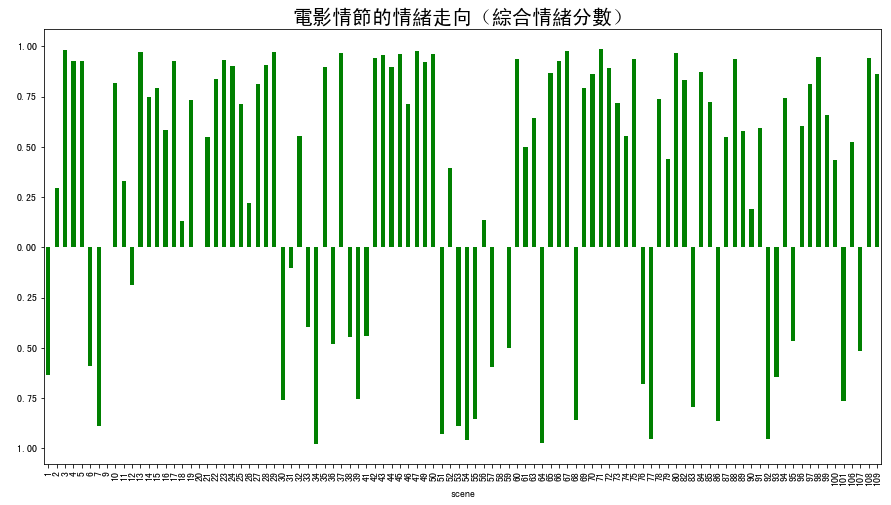

In [1148]:
#依分幕畫出情節的情緒走向
plt.figure(figsize=(15,8))
df_scene['positive'].plot(kind = 'bar',  color='red')
df_scene['negative'].multiply(-1).plot(kind = 'bar')
plt.title('電影情節的情緒走向（紅:positive, 藍:negative）', fontsize=20)

plt.figure(figsize=(15,8))
df_scene['compound'].plot(kind = 'bar', color='green')
plt.title('電影情節的情緒走向（綜合情緒分數）', fontsize=20)

### B. 依角色來分析情緒走向

In [1141]:
#根據角色＆分幕來分析
df_scene_chara = df_script.groupby(['scene','main_chara'])['dialogue'].apply(' '.join).reset_index()
df_scene_chara['scene'] = df_scene_chara['scene'].apply(lambda x: int(x))
df_scene_chara.sort_values('scene', inplace=True)
df_scene_chara.head()

,scene,main_chara,dialogue
0,1,JUDY HOPPS,"Blood, blood, blood! And death."
37,2,JUDY HOPPS,"Back then, the world was divided in two. Vicio..."
60,3,GIDEON GREY,Bunny cop. That is the most stupidest thing I ...
61,3,JUDY HOPPS,And I can make the world a better place! I am ...
88,4,JUDY HOPPS,"Oh yes, that's right, Stu. We settled hard. 4...."


### 1) 先看女主角Judy在不同時期的情緒: 孩童時期情緒很正面，成人後有較多負面情緒


In [1142]:
#將不同時期的台詞編碼
judy = df_text[df_text['main_chara'] == 'JUDY HOPPS']
judy = judy.groupby(['character','scene'])['dialogue'].apply(' '.join).reset_index()
judy.loc[judy.character == 'STU HOPPS', 'stage'] = 'stu'
judy.loc[judy.character == 'BONNIE HOPPS', 'stage'] = 'young'
judy.loc[judy.character == 'YOUNG JUDY', 'stage'] = 'young'
judy.loc[judy.character == 'HOPPS', 'stage'] = 'adult'
judy.loc[judy.character == 'JUDY', 'stage'] = 'adult'

In [1143]:
judy['scene'] = judy['scene'].apply(lambda x : int(x))
judy.sort_values(by=['scene'], inplace=True)
judy.head()

,character,scene,dialogue,stage
115,YOUNG JUDY,1,"Blood, blood, blood! And death.",young
116,YOUNG JUDY,2,"Back then, the world was divided in two. Vicio...",young
117,YOUNG JUDY,3,And I can make the world a better place! I am ...,young
107,STU HOPPS,3,"Judy, you ever wonder how your mom and me got ...",stu
118,YOUNG JUDY,4,"I like trying, actually. Oh. Then I guess I'l...",young


In [1144]:
#加入情緒分數的欄位
judy['compound'] = None

for i in range(len(judy)):
    text = judy.iloc[i]['dialogue']
    com = sentiment_analyzer_scores(text)['compound']
    judy.iloc[i,4] = com
judy.head()     

,character,scene,dialogue,stage,compound
115,YOUNG JUDY,1,"Blood, blood, blood! And death.",young,-0.636
116,YOUNG JUDY,2,"Back then, the world was divided in two. Vicio...",young,0.296
117,YOUNG JUDY,3,And I can make the world a better place! I am ...,young,0.971
107,STU HOPPS,3,"Judy, you ever wonder how your mom and me got ...",stu,0.8556
118,YOUNG JUDY,4,"I like trying, actually. Oh. Then I guess I'l...",young,0.69


Text(0.5, 1.0, 'Judy不同時期的情緒走向（綜合情緒分數）')

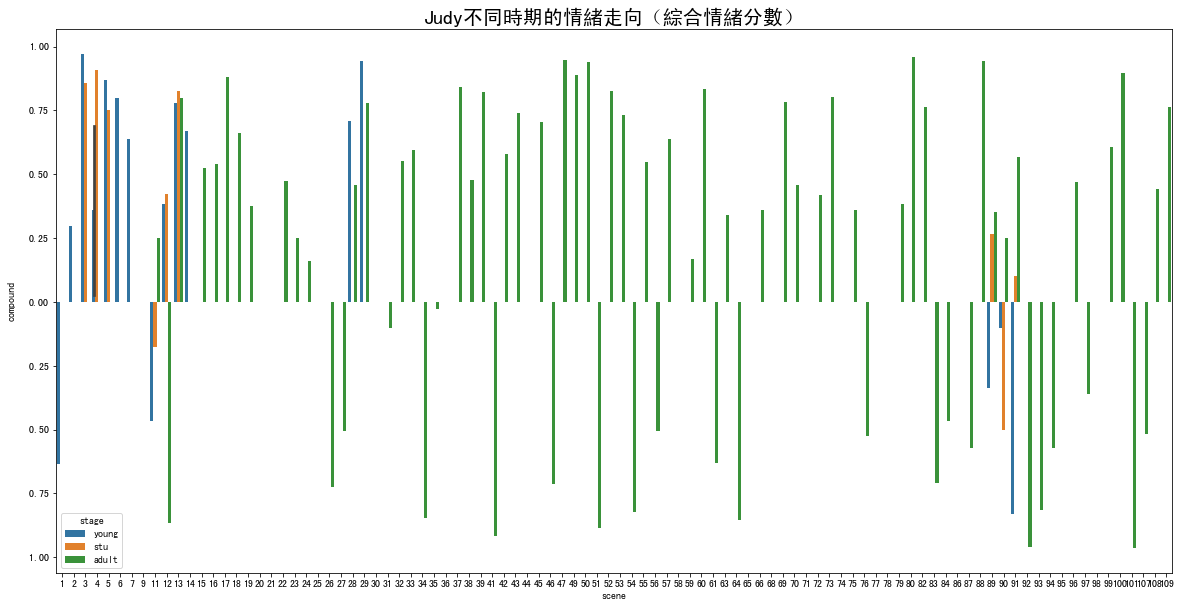

In [1150]:
#judy不同時期的情緒圖
plt.figure(figsize=(20,10))
sns.barplot(data = judy, x = 'scene', y = 'compound', hue = 'stage')
plt.title('Judy不同時期的情緒走向（綜合情緒分數）', fontsize=20)

### 2) 比較男女主角的情緒差異: Judy很樂觀，Nick很厭世

In [1151]:
#Judy的整體情緒
judy = df_scene_chara[df_scene_chara['main_chara'] == 'JUDY HOPPS']

judy['compound'] = None

for i in range(len(judy)):
    text = judy.iloc[i]['dialogue']
    com = sentiment_analyzer_scores(text)['compound']
    judy.iloc[i,3] = com
judy.head()     

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,scene,main_chara,dialogue,compound
0,1,JUDY HOPPS,"Blood, blood, blood! And death.",-0.636
37,2,JUDY HOPPS,"Back then, the world was divided in two. Vicio...",0.296
61,3,JUDY HOPPS,And I can make the world a better place! I am ...,0.9847
88,4,JUDY HOPPS,"Oh yes, that's right, Stu. We settled hard. 4....",0.9278
114,5,JUDY HOPPS,"Yes! Your dad, me, your 275 brothers and siste...",0.945


Text(0.5, 1.0, 'Judy的情緒走向（綜合情緒分數）')

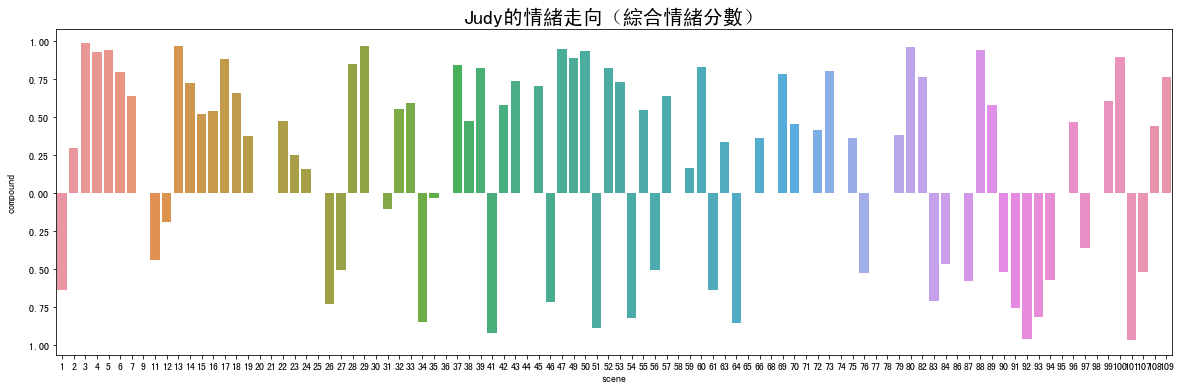

In [1152]:
plt.figure(figsize=(20,6))
sns.barplot(data=judy, x='scene', y='compound')
plt.title('Judy的情緒走向（綜合情緒分數）', fontsize=20)

Judy整體來說都很開朗，除了中後期隨著情節的進展開始有較多的負面情緒

In [989]:
#nick的整體情緒走向
nick = df_scene_chara[df_scene_chara['main_chara'] == 'NICK WILDE']

nick['compound'] = None

for i in range(len(nick)):
    text = nick.iloc[i]['dialogue']
    com = sentiment_analyzer_scores(text)['compound']
    nick.iloc[i,3] = com
nick.head()     

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,scene,main_chara,dialogue,compound
41,21,NICK WILDE,"I'm not looking for any trouble either, sir. I...",-0.592
44,22,NICK WILDE,A Jumbo Pop. Please.,0.3182
47,23,NICK WILDE,Thank you so much. (to Hopps) Thank you. (then...,0.9164
49,24,NICK WILDE,"Wilde. Nick Wilde. 24. Ah, boy, I tell him th...",0.8881
52,25,NICK WILDE,Pawpsicles! Get your pawpsicles! Lumber deliv...,0.4284


Text(0.5, 1.0, 'Nick的情緒走向（綜合情緒分數）')

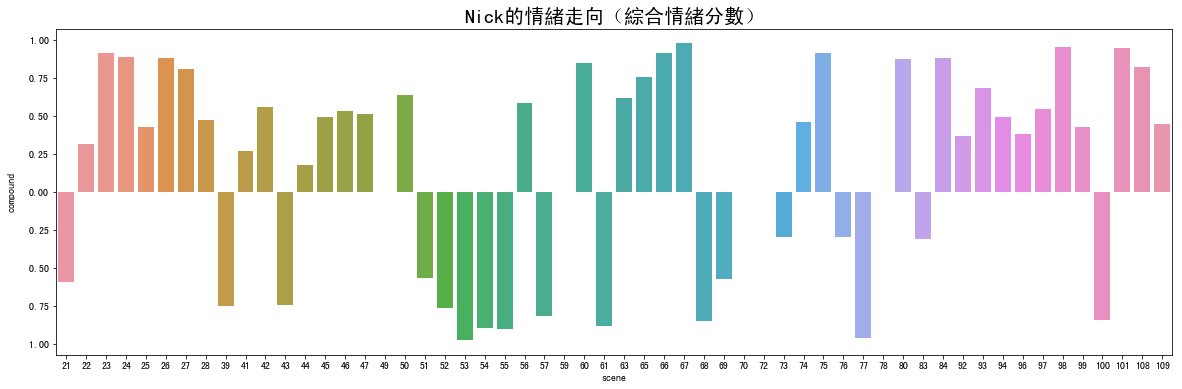

In [1153]:
plt.figure(figsize=(20,6))
sns.barplot(data=nick, x='scene', y='compound')
plt.title('Nick的情緒走向（綜合情緒分數）', fontsize=20)

Nick前期正面（因為在玩弄Judy），中期開始顯露厭世的本性，後期又變得開朗